In [2]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [3]:
import torch

In [4]:
import torch

print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))

Torch version:2.3.0a0+ebedce2
cuda version: 12.3
cudnn version:90000


In [5]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0


In [6]:
!cat /usr/include/x86_64-linux-gnu/cudnn_v*.h | grep CUDNN_MAJOR -A 2


#define CUDNN_MAJOR 9
#define CUDNN_MINOR 0
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 10000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

/* cannot use constexpr here since this is a C-only file */
--
#define CUDNN_MAJOR 9
#define CUDNN_MINOR 0
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 10000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

/* cannot use constexpr here since this is a C-only file */


In [7]:
!pip3 install triton

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [8]:
import torch

import triton
import triton.language as tl

@triton.jit
def add_kernel(
    x_ptr, # pointer to first input vector
    y_ptr, # pointer to second input vector
    output_ptr, # pointer to output vector
    n_elements, # size of the vector
    BLOCK_SIZE : tl.constexpr # number of elements each program should process
    ):

    pid = tl.program_id(axis = 0) # we use 1d grid

    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE) # offset is list of pointers

    # create mask guard to avoid out of bound accesss
    mask = offsets < n_elements

    # load x and y from DRAM
    # mask out any extra elements in case the input is not a multiple of block
    x = tl.load(x_ptr + offsets, mask = mask)
    y = tl.load(y_ptr + offsets, mask = mask)
    output = x + y

    # write x+y back to DRAM
    tl.store(output_ptr + offsets, output, mask = mask)

def add(x :torch.Tensor, y: torch.Tensor):
    # preallocate output
    output = torch.empty_like(x)
    assert x.is_cuda and y.is_cuda and output.is_cuda
    n_elements = output.numel()

    # 'SMPD launch' grid denotes the number of kernel instances that run in parallel
    # It is analogous to CUDA launch grids
    # we use 1D grid where the size is the number of blocks
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)

    return output

torch.manual_seed(0)
size = 98432
x = torch.rand(size, device='cuda')
y = torch.rand(size, device='cuda')
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
The maximum difference between torch and triton is 0.0


In [9]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    y = torch.rand(size, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
    gbps = lambda ms: 12 * size / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

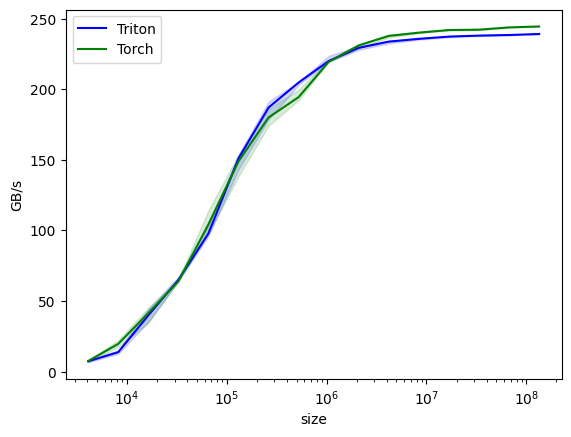

vector-add-performance:
           size      Triton       Torch
0        4096.0    7.349282    7.566502
1        8192.0   13.837838   19.692308
2       16384.0   39.896105   41.513512
3       32768.0   65.015874   63.999998
4       65536.0   97.912354  104.356686
5      131072.0  151.004606  148.945450
6      262144.0  187.067560  180.043948
7      524288.0  204.800005  194.468840
8     1048576.0  220.042531  219.428568
9     2097152.0  229.347329  231.099613
10    4194304.0  233.778834  237.826266
11    8388608.0  235.723336  240.104424
12   16777216.0  237.323876  241.979072
13   33554432.0  238.024212  242.221299
14   67108864.0  238.454993  243.847798
15  134217728.0  239.176799  244.486228


In [10]:
benchmark.run(print_data=True, show_plots=True)